In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import numpy as np
from math import *
from scipy.signal import argrelextrema

import networkx as nx

import seaborn as sns
sns.set()
sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 4.0})

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
def readEdges(filename):
    edges=np.loadtxt(filename)
    edges.sort()
    edges.sort(axis=0)
    return edges

def readTrigs(filename):
    trigs=np.loadtxt(filename)
    trigs.sort()
    trigs.sort(axis=0)
    return trigs

In [3]:
def B1fromEdges(n, edges):
    B1=np.zeros((n, edges.shape[0]))

    for i in range(edges.shape[0]):
        B1[int(edges[i, 0]),i]=-1
        B1[int(edges[i, 1]),i]=1
    return B1

def B2fromTrig(n, edges, trigs):
    B2=np.zeros((len(edges), trigs.shape[0]))

    for i in range(trigs.shape[0]):
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 1]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 0], trigs[i, 2]])).all(axis=1))[0][0] ,i]=1
        B2[np.where((edges==np.array([trigs[i, 1], trigs[i, 2]])).all(axis=1))[0][0] ,i]=-1
    return B2

In [4]:
n=6
edges=readEdges('6.edges')
trigs=readTrigs('6.trigs')

In [5]:
B1=B1fromEdges(n, edges)
B2=B2fromTrig(n, edges, trigs)

In [6]:
def getRandomWeights(edges):
    return np.random.uniform(size=(edges.shape[0]))

In [48]:
w=getRandomWeights(edges)
w=np.array([1, 1, 0.5, 1, 1, 1, 1, 1])

In [8]:
def getAdjB1(B1):
    return np.diag(np.diag(B1.dot(B1.T)))-B1.dot(B1.T)

In [9]:
A=getAdjB1(B1)
G = nx.from_numpy_matrix(np.array(A))  
pos = nx.spring_layout(G)

In [10]:
def getPosFromB1(B1):
    A=getAdjB1(B1)
    G = nx.from_numpy_matrix(np.array(A))  
    pos = nx.spring_layout(G)
    return np.array(list(pos.values()))

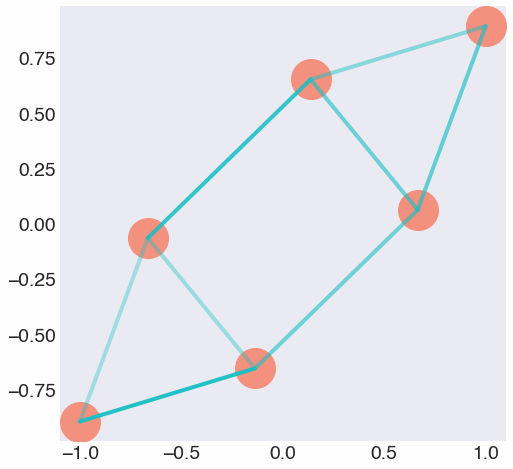

In [11]:
points=getPosFromB1(B1)
plt.figure(figsize=(8,8))
#plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

for i in range(edges.shape[0]):
    plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=np.sqrt(w[i]))
plt.grid(False)

([], [])

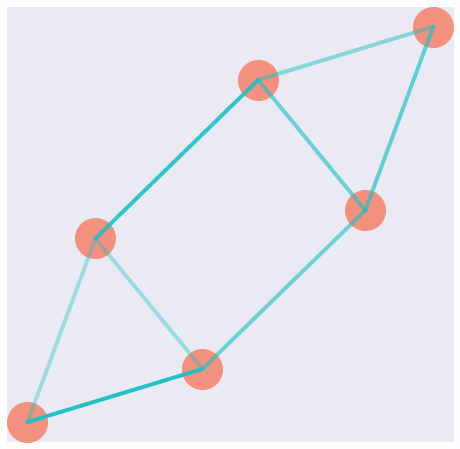

In [12]:
plt.figure(figsize=(8,8))
plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

for i in range(edges.shape[0]):
    plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=np.sqrt(w[i]))
plt.grid(False)
plt.xticks([], [])
plt.yticks([], [])

In [13]:
def simpleDrawB1(B1, w, eps=0, e=0):
    points=getPosFromB1(B1)
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)

    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])

In [14]:
def HodgeLW_fr(B1, B2, w, e=0, eps=0):
    W=np.diag(np.sqrt(w)+eps*e)
    Dt=np.diag(B2.T.dot(np.diag(W.dot(W))))
    L1=W.dot(B1.T.dot(B1.dot(W)))+B2.dot(Dt.dot(B2.T))
    return L1

In [15]:
L1=HodgeLW_fr(B1, B2, w)
L1

array([[ 0.7176212 ,  0.58011176, -0.55901812, -0.40785452,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.58011176,  1.11217731,  0.11219325,  0.        , -0.38189957,
         0.        ,  0.        ,  0.        ],
       [-0.55901812,  0.11219325,  1.000076  ,  0.52237531, -0.35536034,
         0.        ,  0.        ,  0.        ],
       [-0.40785452,  0.        ,  0.52237531,  1.50864009,  0.        ,
        -0.32079969, -0.30956144,  0.        ],
       [ 0.        , -0.38189957, -0.35536034,  0.        ,  0.69816532,
         0.21823292,  0.        , -0.56647502],
       [ 0.        ,  0.        ,  0.        , -0.32079969,  0.21823292,
        -0.38291764, -0.52412782,  0.30164095],
       [ 0.        ,  0.        ,  0.        , -0.30956144,  0.        ,
        -0.52412782, -0.40170053,  0.99751113],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.56647502,
         0.30164095,  0.99751113,  1.1827192 ]])

$$
F(L_1(W))=\sum_{i=1}^{k+1} \lambda_i^2=\sum_{i=1}^{k+1} (x_i^T L_1 x_i)^2
$$

In [16]:
def getL1k(L1, thr=1e-8):
    return np.sum(np.abs(np.linalg.eig(L1)[0])<thr)

In [17]:
k=getL1k(L1)
k

1

In [108]:
def getFk_l2(L1, k, thr=1e-8):
    #k=getL1k(L1, thr=thr)
    vals, vecs=np.linalg.eig(L1)
    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs = vecs[:,idx]
    
    ans=0
    for i in range(k+1):
        ans+=(vecs[:, i].T.dot(L1.dot(vecs[:, i])))**2
    
    return np.sum(np.power(vals[:k+1], 2)), ans

In [109]:
getFk_l2(L1, 1)

(8.765084434907372, 8.765084434907335)

In [20]:
eps=0.5
e=np.random.uniform(size=w.shape[0])
e=e/np.linalg.norm(e)

In [21]:
def Sym(A):
    return 0.5*(A+A.T)

In [118]:
L1_E=HodgeLW_fr(B1, B2, w, e, eps)
vals, vecs=np.linalg.eig(L1_E)
idx = vals.argsort()[::-1]   
vals = vals[idx]
vecs = vecs[:,idx]

def getG_i(i, B1, B2, L1_E, vecs, w, e, eps):
    W=np.diag(np.sqrt(w)+eps*e)
    x=vecs[:, i].reshape(-1, 1)
    Gi=2*Sym(x.dot(x.T.dot(W.dot(B1.T.dot(B1)))))+2*np.diag(np.diag(B2.T.dot(x.dot(x.T.dot(B2)))).T.dot(B2.T.dot(W)))
    return x.T.dot(L1_E.dot(x))*Gi

In [120]:
getG_i(0, B1, B2, L1_E, vecs, w, e, eps)

array([[ 1.68908172, -0.67341947, -1.71099978, -1.40957827,  1.95661338,
         1.74615482,  0.32622317, -1.75271393],
       [-0.67341947,  1.51832389,  1.40837833,  1.14399315, -1.58616107,
        -1.41217173, -0.27860539,  1.46427391],
       [-1.71099978,  1.40837833,  2.45545902,  2.92637464, -4.06286664,
        -3.62737966, -0.67100471,  3.6198648 ],
       [-1.40957827,  1.14399315,  2.92637464,  2.40670984, -3.3402593 ,
        -2.98011406, -0.56051016,  3.00319633],
       [ 1.95661338, -1.58616107, -4.06286664, -3.3402593 ,  4.635803  ,
         4.13573902,  0.77888743, -4.17101264],
       [ 1.74615482, -1.41217173, -3.62737966, -2.98011406,  4.13573902,
         7.17993289,  0.69670914, -3.72673206],
       [ 0.32622317, -0.27860539, -0.67100471, -0.56051016,  0.77888743,
         0.69670914,  3.89103671, -0.67714513],
       [-1.75271393,  1.46427391,  3.6198648 ,  3.00319633, -4.17101264,
        -3.72673206, -0.67714513, -1.11250303]])

In [24]:
def scal(A, B):
    return np.trace(A.T.dot(B))

In [121]:
def getDotE(B1, B2, w, e, eps, k, thr=1e-8):
    mask=(np.abs(w+eps*e)<thr)
    matmask=np.diag(np.logical_not((np.abs(w+eps*e)<1e-8)))
    E=np.diag(e)
    PE=np.multiply(E, matmask)
    
    L1_E=HodgeLW_fr(B1, B2, w, e, eps)
    vals, vecs=np.linalg.eig(L1_E)
    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs = vecs[:,idx]
    #k=np.sum(np.abs(vals)<thr)

    GE=np.zeros(L1_E.shape)
    for i in range(k+1):
        GE+=getG_i(i, B1, B2, L1_E, vecs, w, e, eps)
    
    kappa=scal(-GE, PE)/scal(PE, PE)
    PGE=np.multiply(GE, matmask)
    dE=-PGE-kappa*PE
    return dE

In [26]:
matmask=np.diag(np.logical_not((np.abs(w+eps*e)<1e-8)))

In [122]:
#e=np.random.uniform(size=w.shape[0])
#e=e/np.linalg.norm(e)
e=np.array([1,0,0,0,0,0,0,0])
eps=0.7

track=[]
h=1e-3
t_cur=0
log=[]
for i in range(10000):
    h=1e-3
    e0=e
    while True:
        e=e0
        dE=getDotE(B1, B2, w, e, eps, 1)
        E1=np.diag(e)+h*dE
        e=np.diag(E1)
        if np.sum(np.sqrt(w)+eps*e<0)>0:
            h=h/2
        else:
            break
    L1_E=HodgeLW_fr(B1, B2, w, e, eps)
    log.append(np.sort(np.linalg.eig(L1_E)[0]))
    track.append(getFk_l2(L1_E, 1)[0])
    dE=getDotE(B1, B2, w, e, eps, 1)
    
    if i % 200 ==0:
        print('time: ', t_cur, ' ||   E_norm:', scal(E1, E1), ',    dE-orth:', scal(dE, E1), getFk_l2(L1_E, 1)[0], np.sum((np.sort(np.linalg.eig(L1_E)[0])[:2])**2))
    t_cur+=h
    #print(scal(E1, dE), end=' ')
    #print(track[-1])

time:  0  ||   E_norm: 1.0208333740359845 ,    dE-orth: 5.329070518200751e-15 255.0075550184485 0.16716026738364487
time:  0.20000000000000015  ||   E_norm: 1.205739388864334 ,    dE-orth: -6.696032617270475e-16 14.4530782456936 0.0007171057695948802
time:  0.4000000000000003  ||   E_norm: 1.2057404596726786 ,    dE-orth: 1.2277776451768974e-15 14.451585395186637 0.0006751768732807848
time:  0.6000000000000004  ||   E_norm: 1.2057404597671875 ,    dE-orth: 2.0775083923682026e-15 14.451585263355557 0.0006748142844349667
time:  0.8000000000000006  ||   E_norm: 1.2057404597671995 ,    dE-orth: 2.323037071782643e-15 14.451585263340373 0.000674810790447954
time:  1.0000000000000007  ||   E_norm: 1.2057404597671997 ,    dE-orth: -1.777054687842489e-16 14.451585263340329 0.0006748107555701971
time:  1.1999999999999786  ||   E_norm: 1.205740459767201 ,    dE-orth: 3.626013982759392e-15 14.451585263340384 0.0006748107552213426
time:  1.3999999999999566  ||   E_norm: 1.2057404597672012 ,    dE-o

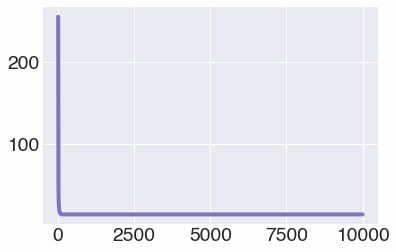

In [123]:
plt.plot(track)

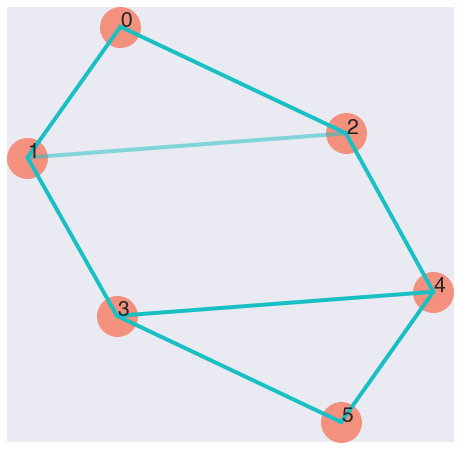

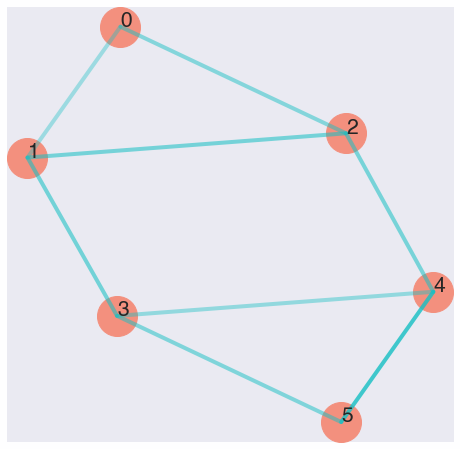

In [124]:
simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

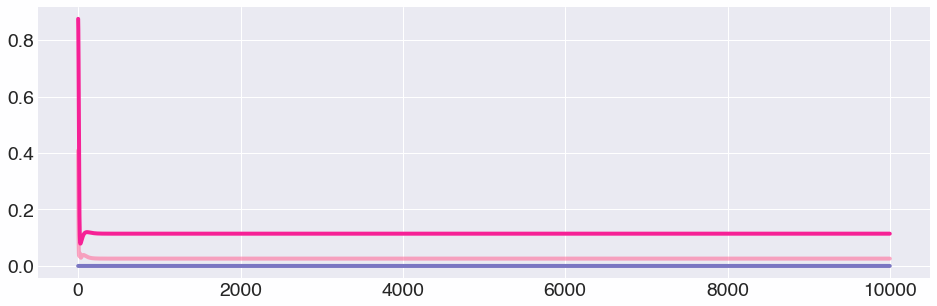

In [125]:
log=np.array(log)

plt.figure(figsize=(16, 5))
plt.plot(log[:, :3])

In [96]:
track[-1]

16.64583969006606

In [52]:
simpleDrawB1(B1, w, e, eps)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 576x576 with 0 Axes>

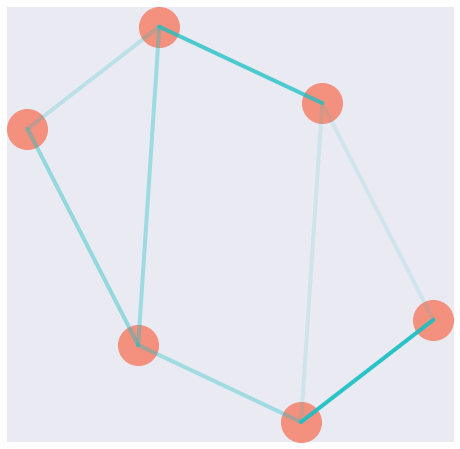

In [34]:
simpleDrawB1(B1, w, e=0, eps=0)

In [35]:
points=getPosFromB1(B1)


In [36]:
def simpleDrawB1(B1, w, points, eps=0, e=0):
    
    plt.figure(figsize=(8,8))
    plt.plot(points[:,0], points[:,1], 'o', color=colors[4], markersize=40)
    for i in range(points.shape[0]):
        plt.annotate(str(i), (points[i,0], points[i,1]))
    for i in range(edges.shape[0]):
        plt.plot(points[edges[i].astype(int), 0], points[edges[i].astype(int), 1], color=colors[3], alpha=((np.sqrt(w)+eps*e)**2)[i])
    plt.grid(False)
    plt.xticks([], [])
    plt.yticks([], [])

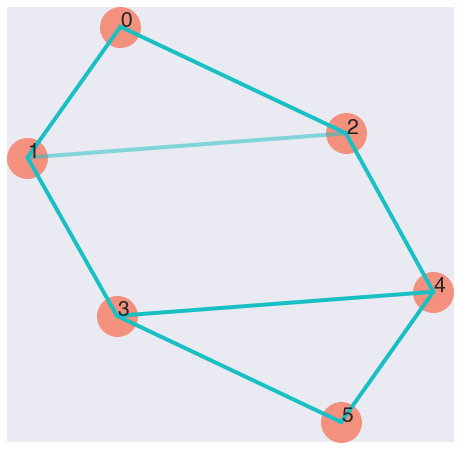

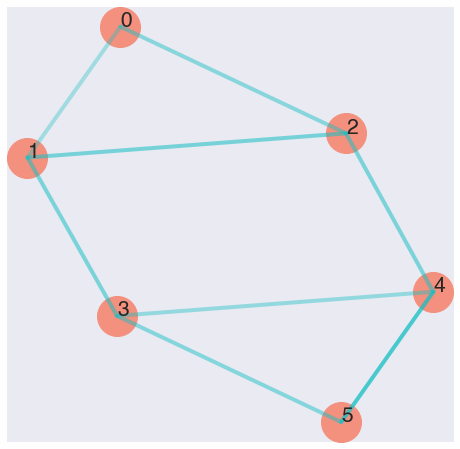

In [117]:
simpleDrawB1(B1, w, points, e=0, eps=0)
simpleDrawB1(B1, w, points, e, eps)

In [130]:
epses=np.arange(0.6, 0.9 , 0.01)
ans=[]
for eps in epses:
    #e=np.random.uniform(size=w.shape[0])
    #e=e/np.linalg.norm(e)
    e=np.array([1, 0, 0, 0, 0, 0, 0, 0])
    track=[]
    h=1e-3
    t_cur=0
    for i in range(10000):
        h=1e-3
        e0=e
        while True:
            e=e0
            dE=getDotE(B1, B2, w, e, eps, 1)
            E1=np.diag(e)+h*dE
            e=np.diag(E1)
            if np.sum(np.sqrt(w)+eps*e<0)>0:
                h=h/2
            else:
                break
        L1_E=HodgeLW_fr(B1, B2, w, e, eps)
        #track.append(getFk_l2(L1_E, 1)[0])
        track.append(np.sum((np.sort(np.linalg.eig(L1_E)[0])[:2])**2))
        dE=getDotE(B1, B2, w, e, eps, 1)
    ans.append(track[-1])
    #print(np.linalg.eig(L1_E)[0], )

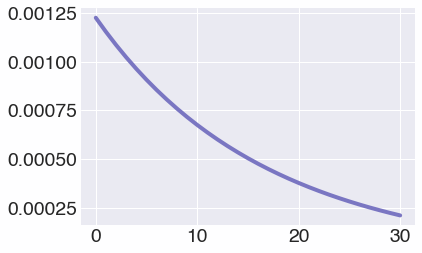

In [131]:
plt.plot(ans)

In [115]:
ans[-1]

0.0005708379363279958

In [126]:
np.sqrt(w)+eps*e

array([0.60856986, 0.69504779, 0.74621545, 0.75692557, 0.73872636,
       0.64844964, 0.71234543, 0.90310815])

In [127]:
np.sqrt(w)

array([1.        , 1.        , 0.70710678, 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [100]:
A=np.array([[1,0,0], [0, 2,0], [0, 3, 0]])
getFk_l2(A, 1)[0]

5.0